<a href="https://colab.research.google.com/github/SteinwayThor/eeg-features-movies/blob/main/EDA_and_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# generic torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# generic ml/stats imports
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.fftpack as sp
from sklearn.model_selection import train_test_split
from math import pi
from scipy.spatial.distance import pdist, squareform
import pandas as pd

#torch vision related imports
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

# data utils
import time
import os
import pickle
import json
from PIL import Image
from google.colab import drive
import bz2
import _pickle as cPickle
import pickle as pl
from scipy.io import loadmat

In [2]:
drive.mount('/content/drive', force_remount=True)

# Load any compressed pickle file
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

Mounted at /content/drive


In [3]:
emotion_annotations_f = '/content/drive/MyDrive/Movie Data/e0018RI/emotion_annotations'
emotion_annotations = os.listdir(emotion_annotations_f)
#skyfall_emotion_[angry|fear|sad|happy|disgust]_viewer[123|127|139|142]_chapter[01 to 31].json

In [36]:
#EDA on emotions json data
diff_emotions = {}
diff_viewers = {}
diff_chapters = {}
for json_file in emotion_annotations:
  split_name = json_file.split("_")
  emotion = split_name[2]  #angry
  viewer = split_name[3]  #viewer127
  chapter = split_name[4][:split_name[4].find(".")]  #chapter01
  diff_emotions[emotion] = diff_emotions.get(emotion,[]) + [json_file]
  diff_viewers[viewer] = diff_viewers.get(viewer,[]) + [json_file]
  diff_chapters[chapter] = diff_chapters.get(chapter,[]) + [json_file]
print(sorted(diff_chapters.keys()), diff_emotions.keys(), diff_viewers.keys(), sep='\n-------\n')

['chapter01', 'chapter02', 'chapter03', 'chapter04', 'chapter05', 'chapter06', 'chapter07', 'chapter08', 'chapter09', 'chapter10', 'chapter11', 'chapter12', 'chapter13', 'chapter14', 'chapter15', 'chapter16', 'chapter17', 'chapter18', 'chapter19', 'chapter20', 'chapter21', 'chapter22', 'chapter23', 'chapter24', 'chapter25', 'chapter26', 'chapter27', 'chapter28', 'chapter29', 'chapter30', 'chapter31']
-------
dict_keys(['disgust', 'angry', 'fear', 'sad', 'happy'])
-------
dict_keys(['viewer142', 'viewer127', 'viewer123', 'viewer139'])


In [37]:
#global insight:
# the file name is in the format: skyfall_emotion_[angry|fear|sad|happy|disgust]_viewer[123|127|139|142]_chapter[01 to 31].json

print("\n======================================================================")
print("Total different CHAPTERS for which labels are available along with their count: ")
print("Total CHAPTERS: ", len(diff_chapters.keys()))
chapter_plot = []
for chapter in sorted(list(diff_chapters.keys())):
  print(chapter, ", number of label files: ", len(diff_chapters[chapter]))
  print("Files:", sorted(diff_chapters[chapter]))
  chapter_plot.append([chapter,len(diff_chapters[chapter])])
chapter_plot = np.array(chapter_plot)
#insights:
# 1. json files for a single chapter represent different emotions corresponding to each file.
# 2. There can be min of 2 and max of 4 emotions/json per chapter.
# 3. Chapter 32 has no emotions data for it (end credits). Implication: Ignore neural data for it.
# 4. We can ignore viewer number in the file name here.

emotion_plot = []
print("\n======================================================================\n")
print("Total different EMOTIONS for which labels are available along with their count: ")
print("Total EMOTIONS: ", len(diff_emotions.keys()))
for emotion in sorted(list(diff_emotions.keys())):
  print(emotion, ", number of label files: ", len(diff_emotions[emotion]), end=',')
  print("Files:", sorted(diff_emotions[emotion]))
  emotion_plot.append([emotion, len(diff_emotions[emotion])])
emotion_plot = np.array(emotion_plot)
#insights:
# 1. 5 total emotions: angry, fear, happy, disgust and sad.
# 2. There is class-imbalance in the emotion classes.
# 3. Most of the data corresponds to negative emotions, possibly because skyfall has a lot of sad and intense scenes.

viewer_plot = []
print("\n======================================================================\n")
print("Total different VIEWERS for which labels are available along with their count: ")
print("Total VIEWERS: ", len(diff_viewers.keys()))
for viewer in sorted(list(diff_viewers.keys())):
  print(viewer, ", number of label files: ", len(diff_viewers[viewer]))
  print("Files:", sorted(diff_viewers[viewer]))
  viewer_plot.append([viewer, len(diff_viewers[viewer])])
viewer_plot = np.array(viewer_plot)
#insights:
# 1. There are 4 distinct viewers but for our purposes, we can just ignore viewer differences in annotation. Assuming no bias in viewers' annotations.


Total different CHAPTERS for which labels are available along with their count: 
Total CHAPTERS:  31
chapter01 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter01.json', 'skyfall_emotion_fear_viewer127_chapter01.json', 'skyfall_emotion_happy_viewer139_chapter01.json', 'skyfall_emotion_sad_viewer123_chapter01.json']
chapter02 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter02.json', 'skyfall_emotion_fear_viewer127_chapter02.json', 'skyfall_emotion_happy_viewer139_chapter02.json', 'skyfall_emotion_sad_viewer123_chapter02.json']
chapter03 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter03.json', 'skyfall_emotion_fear_viewer127_chapter03.json', 'skyfall_emotion_happy_viewer139_chapter03.json', 'skyfall_emotion_sad_viewer123_chapter03.json']
chapter04 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter04.json', 'skyfall_emotion_fear_viewer127_chapter04.json', 'skyfall_emotion_happy_v

[]

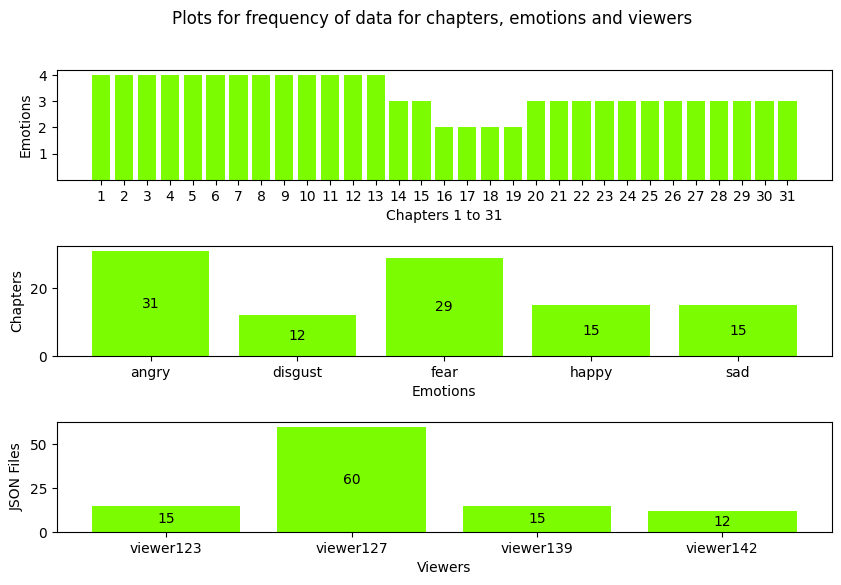

In [6]:
fig, axs = plt.subplots(3,1, figsize=(10,6))
fig.suptitle("Plots for frequency of data for chapters, emotions and viewers")
fig.subplots_adjust(hspace=0.6)

axs[0].bar(range(1,1+chapter_plot.shape[0]),chapter_plot[:,1].astype('int'), color = 'lawngreen')
axs[0].set_xticks(range(1,1+chapter_plot.shape[0]))
axs[0].set_yticks([1,2,3,4])
axs[0].set_ylabel("Emotions")
axs[0].set_xlabel("Chapters 1 to 31")

_ = axs[1].bar(range(1,1+emotion_plot.shape[0]),emotion_plot[:,1].astype('int'), color = 'lawngreen')
axs[1].bar_label(_, label_type='center')
axs[1].set_xticks(range(1,1+emotion_plot.shape[0]), emotion_plot[:,0])
axs[1].set_ylabel("Chapters")
axs[1].set_xlabel("Emotions")

_ = axs[2].bar(range(1,1+viewer_plot.shape[0]),viewer_plot[:,1].astype('int'), color = 'lawngreen')
axs[2].bar_label(_, label_type='center')
axs[2].set_xticks(range(1,1+viewer_plot.shape[0]), viewer_plot[:,0])
axs[2].set_ylabel("JSON Files")
axs[2].set_xlabel("Viewers")
plt.plot()

Extract and sync emotion labels with frame IDs

In [7]:
#chapter wise data extractions
#all the label data for a chapter.
all_data = {}
#key: chapter name
#value: list of json files loaded in/parsed
for x in diff_chapters:
  all_data[x] = []
  for label_file in diff_chapters[x]:
    all_data[x].append(json.load(open(os.path.join(emotion_annotations_f, label_file))))

In [8]:
ch = np.array(['chapter' + str(i).zfill(2) for i in range(1,32)])
print(ch)

['chapter01' 'chapter02' 'chapter03' 'chapter04' 'chapter05' 'chapter06'
 'chapter07' 'chapter08' 'chapter09' 'chapter10' 'chapter11' 'chapter12'
 'chapter13' 'chapter14' 'chapter15' 'chapter16' 'chapter17' 'chapter18'
 'chapter19' 'chapter20' 'chapter21' 'chapter22' 'chapter23' 'chapter24'
 'chapter25' 'chapter26' 'chapter27' 'chapter28' 'chapter29' 'chapter30'
 'chapter31']


In [9]:
all_data.keys(), all_data[ch[0]][0].keys()

(dict_keys(['chapter20', 'chapter21', 'chapter22', 'chapter25', 'chapter23', 'chapter24', 'chapter26', 'chapter28', 'chapter29', 'chapter30', 'chapter27', 'chapter03', 'chapter01', 'chapter31', 'chapter02', 'chapter06', 'chapter04', 'chapter07', 'chapter05', 'chapter12', 'chapter11', 'chapter08', 'chapter10', 'chapter09', 'chapter14', 'chapter15', 'chapter16', 'chapter17', 'chapter13', 'chapter18', 'chapter19']),
 dict_keys(['tags', 'shapes', 'version', 'tracks']))

In [10]:
#All possible values of tags, version and shapes across json files for all chapters
#version: Use of version is not apparent, will figure out its role if the need be in the future, seems random for now.
#tags: Tags is just empty, ignore.
#shapes: only present in 4 chapters. is it useful?? don't think so.
#tracks: useful but what?
tags = [] #unique values of tags across data
versions = [] #unique values of version across data
shapes = {}  #checking for shapes key existence over the json files for each chapter
dict_keys = []
for chapter in all_data:
  tags.extend([len(all_data[chapter][i]['tags']) for i in range(len(all_data[chapter]))])
  versions.extend([all_data[chapter][i]['version'] for i in range(len(all_data[chapter]))])
  dict_keys.extend([len(all_data[chapter][i].keys()) for i in range(len(all_data[chapter]))])
  shapes[chapter] = max([len(all_data[chapter][i]['shapes']) for i in range(len(all_data[chapter]))])
print('versions:',set(versions), '#dict keys:',set(dict_keys), '#tags:',set(tags), 'shape present?',sorted(shapes.items(), key=lambda x: x[1], reverse=True), sep='\n')


versions:
{0, 2, 3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 20, 21}
#dict keys:
{4}
#tags:
{0}
shape present?
[('chapter23', 1), ('chapter26', 1), ('chapter28', 1), ('chapter01', 1), ('chapter20', 0), ('chapter21', 0), ('chapter22', 0), ('chapter25', 0), ('chapter24', 0), ('chapter29', 0), ('chapter30', 0), ('chapter27', 0), ('chapter03', 0), ('chapter31', 0), ('chapter02', 0), ('chapter06', 0), ('chapter04', 0), ('chapter07', 0), ('chapter05', 0), ('chapter12', 0), ('chapter11', 0), ('chapter08', 0), ('chapter10', 0), ('chapter09', 0), ('chapter14', 0), ('chapter15', 0), ('chapter16', 0), ('chapter17', 0), ('chapter13', 0), ('chapter18', 0), ('chapter19', 0)]


In [11]:
#printing shapes where they exist
#shapes for each chapter and each json file seem to be exact copy across the json files. frame and character name is same.
print(ch[[0,22,25,27]])
for chapter in ch[[0,22,25,27]]:
  print(len([c['shapes'] for c in all_data[chapter]]), [c['shapes'] for c in all_data[chapter]])

['chapter01' 'chapter23' 'chapter26' 'chapter28']
4 [[{'type': 'rectangle', 'occluded': False, 'z_order': 0, 'points': [662.43, 34.99, 941.33, 333.38], 'id': 137882, 'frame': 6132, 'label_id': 2819, 'group': 0, 'attributes': [{'spec_id': 7845, 'value': 'Eve'}]}], [{'type': 'rectangle', 'occluded': False, 'z_order': 0, 'points': [662.43, 34.99, 941.33, 333.38], 'id': 137876, 'frame': 6132, 'label_id': 2771, 'group': 0, 'attributes': [{'spec_id': 7701, 'value': 'Eve'}]}], [{'type': 'rectangle', 'occluded': False, 'z_order': 0, 'points': [662.43, 34.99, 941.33, 333.38], 'id': 137875, 'frame': 6132, 'label_id': 2755, 'group': 0, 'attributes': [{'spec_id': 7659, 'value': 'Eve'}]}], [{'type': 'rectangle', 'occluded': False, 'z_order': 0, 'points': [662.43, 34.99, 941.33, 333.38], 'id': 137881, 'frame': 6132, 'label_id': 2740, 'group': 0, 'attributes': [{'spec_id': 7614, 'value': 'Eve'}]}]]
3 [[{'type': 'rectangle', 'occluded': False, 'z_order': 0, 'points': [592.22, 0.0, 811.77, 163.84], 'id

Above EDA proves that only 'tracks' is the JSON key which seems to have any meaningful data, rest keys are empty or don't have any meaningful data.

In [109]:
chapter_seq_len = {}
for chapter in all_data:
  chapter_seq_len[chapter] = [len(all_data[chapter][i]['tracks']) for i in range(len(all_data[chapter]))]
#chapter_seq_len
sorted(chapter_seq_len.items(), key=lambda x: x[0])

[('chapter01', [62, 62, 62, 62]),
 ('chapter02', [47, 47, 47, 47]),
 ('chapter03', [76, 76, 76, 76]),
 ('chapter04', [2, 2, 2, 2]),
 ('chapter05', [57, 57, 57, 57]),
 ('chapter06', [14, 14, 14, 14]),
 ('chapter07', [48, 48, 48, 48]),
 ('chapter08', [52, 52, 52, 52]),
 ('chapter09', [56, 56, 56, 56]),
 ('chapter10', [15, 15, 15, 15]),
 ('chapter11', [39, 39, 39, 39]),
 ('chapter12', [25, 25, 25, 0]),
 ('chapter13', [39, 39, 39, 0]),
 ('chapter14', [22, 0, 24]),
 ('chapter15', [0, 0, 45]),
 ('chapter16', [24, 24]),
 ('chapter17', [64, 64]),
 ('chapter18', [34, 34]),
 ('chapter19', [58, 58]),
 ('chapter20', [42, 42, 42]),
 ('chapter21', [84, 84, 84]),
 ('chapter22', [47, 47, 47]),
 ('chapter23', [80, 80, 80]),
 ('chapter24', [26, 26, 26]),
 ('chapter25', [48, 48, 48]),
 ('chapter26', [18, 18, 18]),
 ('chapter27', [29, 29, 29]),
 ('chapter28', [49, 49, 49]),
 ('chapter29', [70, 70, 58]),
 ('chapter30', [56, 56, 56]),
 ('chapter31', [34, 34, 34])]

In [115]:
df = []
len_rows = 0
chapter = ch[0]
for pos,json_array in enumerate(all_data[chapter]):
  print('adding to df file:', diff_chapters[chapter][pos])
  df.append(pd.DataFrame(json_array['tracks']))
  len_rows += len(json_array['tracks'])
  print(len(json_array['tracks']))
df = pd.concat(df)
print(len_rows)

adding to df file: skyfall_emotion_angry_viewer127_chapter01.json
62
adding to df file: skyfall_emotion_fear_viewer127_chapter01.json
62
adding to df file: skyfall_emotion_sad_viewer123_chapter01.json
62
adding to df file: skyfall_emotion_happy_viewer139_chapter01.json
62
248


In [116]:
df

,id,frame,label_id,group,shapes,attributes
0,547690,1289,2819,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7845, 'value': 'James'}]"
1,547691,1711,2819,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7845, 'value': 'James'}]"
2,547692,1958,2819,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7845, 'value': 'James'}]"
3,547693,2151,2819,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7845, 'value': 'James'}]"
4,547694,2388,2819,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7845, 'value': 'James'}]"
...,...,...,...,...,...,...
57,547279,3695,2740,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7614, 'value': 'Bill'}]"
58,547280,3845,2740,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7614, 'value': 'Bill'}]"
59,547281,5302,2740,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7614, 'value': 'Eve'}]"
60,547282,5302,2740,0,"[{'type': 'rectangle', 'occluded': False, 'z_o...","[{'spec_id': 7614, 'value': 'James'}]"


In [112]:
set(df['label_id'])

{2737, 2752, 2768, 2816}

In [117]:
shape_df = []
for row in df[df['label_id'].isin(set(df['label_id'])) & (df['frame'] == min(df['frame']))].shapes:
  shape_df.append(pd.DataFrame(row))
shape_df = pd.concat(shape_df)
print(len(set(shape_df.frame)), len(set(shape_df.id)))
shape_df
#shape_df[shape_df.frame == min(shape_df.frame)]


7 28


,type,occluded,z_order,points,id,frame,outside,attributes
0,rectangle,False,0,"[430.95, 14.9, 791.54, 421.63]",11942531,1289,False,[]
1,rectangle,False,0,"[369.42, 8.1, 757.4, 433.59]",11942532,1304,False,[]
2,rectangle,False,0,"[333.53, 7.25, 721.51, 432.74]",11942533,1358,False,[]
3,rectangle,False,0,"[283.97, 8.96, 671.95, 434.45]",11942534,1375,False,[]
4,rectangle,False,0,"[317.22, 8.16, 705.2, 433.65]",11942535,1427,False,[]
5,rectangle,False,0,"[368.57, 10.67, 756.55, 436.16]",11942536,1446,False,[]
6,rectangle,False,0,"[368.57, 10.67, 756.55, 436.16]",11942537,1456,True,[]
0,rectangle,False,0,"[430.95, 14.9, 791.54, 421.63]",11921943,1289,False,[]
1,rectangle,False,0,"[369.42, 8.1, 757.4, 433.59]",11921944,1304,False,[]
2,rectangle,False,0,"[333.53, 7.25, 721.51, 432.74]",11921945,1358,False,[]


In [ ]:
f = open(os.path.join(emotion_annotations_f, emotion_annotations[0]))
data = json.load(f)
print(emotion_annotations[0])

json_formatted_str = json.dumps(data, indent=2)
print(json_formatted_str)


In [19]:
#data
# Create an empty array
#print(data["tracks"])
label_frames = []
for track in data["tracks"]:
    shapes = track["shapes"]
    frame = shapes[0]["frame"]
    attributes = shapes[0]["attributes"]
    if attributes != []:
        emotion = attributes[0]["value"]
        label_frames.append((emotion, frame))

def find_last_frame(data):
    last_frame = 0
    for track in data["tracks"]:
        shapes = track["shapes"][-1]
        frame = shapes["frame"]
        last_frame = frame
    return last_frame

def create_tuple_array(data):
    emotions_frames = []
    current_emotion = "not_angry" #get last emotion from previous dataset
    for i in range(find_last_frame(data)):
        if i in label_frames:
            current_emotion = label_frames[0]
        pair = (current_emotion, i)
        emotions_frames.append(pair)
    return emotions_frames
print(len(create_tuple_array(data)))

8146


In [24]:
set(np.array(create_tuple_array(data))[:,0])

{'not_angry'}

In [ ]:
# Load in neural data
# NOTE: Takes a while!
neural_data_folder = '/content/drive/MyDrive/Movie Data/e0018RI/2023-04-02_e0018RI_00'

neural_data_dir = os.listdir(neural_data_folder)

neural_data = {}
channels = []
for f in neural_data_dir:
  channel_name = f[f.rfind('_')+1:-5]
  channels.append(channel_name)
  # channel_data = decompress_pickle(os.path.join(neural_data_folder, f))
  # neural_data[channel_name] = channel_data

print(channels)

['Events', 'PULV15', 'PULV14', 'PULV13', 'PULV12', 'PULV11', 'PULV10', 'PULV9', 'PULV8', 'PULV7', 'PULV6', 'PULV5', 'PULV4', 'PULV3', 'PULV2', 'PULV1', 'TPOCC10', 'TPOCC9', 'TPOCC8', 'TPOCC7', 'TPOCC6', 'TPOCC5', 'TPOCC4', 'TPOCC3', 'TPOCC2', 'TPOCC1', 'TOCC12', 'TOCC11', 'TOCC10', 'TOCC9', 'TOCC8', 'TOCC7', 'TOCC6', 'TOCC5', 'TOCC4', 'TOCC3', 'TOCC2', 'TOCC1', 'POCC10', 'POCC9', 'POCC8', 'POCC7', 'POCC6', 'POCC5', 'POCC4', 'POCC3', 'POCC2', 'POCC1', 'OSLAT10', 'OSLAT9', 'OSLAT8', 'OSLAT7', 'OSLAT6', 'OSLAT5', 'OSLAT4', 'OSLAT3', 'OSLAT2', 'OSLAT1', 'OSUP15', 'OSUP14', 'OSUP13', 'OSUP12', 'OSUP11', 'OSUP10', 'OSUP9', 'OSUP8', 'OSUP7', 'OSUP6', 'OSUP5', 'OSUP4', 'OSUP3', 'OSUP2', 'OSUP1', 'OLAT15', 'OLAT14', 'OLAT13', 'OLAT12', 'OLAT11', 'OLAT10', 'OLAT9', 'OLAT8', 'OLAT7', 'OLAT6', 'OLAT5', 'OLAT4', 'OLAT3', 'OLAT2', 'OLAT1']


In [ ]:
skyfall_cfg2 = loadmat('/content/drive/MyDrive/Movie Data/e0018RI/skyfall_cfg2.mat')
patient_skyfall = loadmat('/content/drive/MyDrive/Movie Data/e0018RI/2023-04-02_e0018RI_skyfall.mat')

#both look like irrelevant files

/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


Points:
1. Alex, Torsten were hopeful with the current annotation data. Try to redump the annotations because we have acces to Alekh website. Not more than 1 hour.
2. DEAP dataset -> labels and spectrograms. 2-3 hrs. We'll reuse Josh's VGG code.
3. Silver lining -> Include the analysis of the data in our report. Constructive criticism of the EEG (spikes between chapters) and the labels.

From the professor's persepctive, the data doesn't matter.

# Emotion wise processing of chapters

* Connect all chapters and all emotion files across chapters. Make a big sequence of frames, emotions.
* diff_emotions

In [120]:
for k in diff_emotions:
  diff_emotions[k] = sorted(diff_emotions[k], key = lambda x: x.split('_')[4])

In [121]:
print("Total different EMOTIONS for which labels are available along with their count: ")
print("Total EMOTIONS: ", len(diff_emotions.keys()))
for emotion in sorted(list(diff_emotions.keys())):
  print(emotion, ", number of label files: ", len(diff_emotions[emotion]), end=',')
  print("Files:", sorted(diff_emotions[emotion]))

Total different EMOTIONS for which labels are available along with their count: 
Total EMOTIONS:  5
angry , number of label files:  31,Files: ['skyfall_emotion_angry_viewer127_chapter01.json', 'skyfall_emotion_angry_viewer127_chapter02.json', 'skyfall_emotion_angry_viewer127_chapter03.json', 'skyfall_emotion_angry_viewer127_chapter04.json', 'skyfall_emotion_angry_viewer127_chapter05.json', 'skyfall_emotion_angry_viewer127_chapter06.json', 'skyfall_emotion_angry_viewer127_chapter07.json', 'skyfall_emotion_angry_viewer127_chapter08.json', 'skyfall_emotion_angry_viewer127_chapter09.json', 'skyfall_emotion_angry_viewer127_chapter10.json', 'skyfall_emotion_angry_viewer127_chapter11.json', 'skyfall_emotion_angry_viewer127_chapter12.json', 'skyfall_emotion_angry_viewer127_chapter13.json', 'skyfall_emotion_angry_viewer127_chapter14.json', 'skyfall_emotion_angry_viewer127_chapter15.json', 'skyfall_emotion_angry_viewer127_chapter16.json', 'skyfall_emotion_angry_viewer127_chapter17.json', 'skyfal

In [309]:
#new dataframe which merges all the json files that we have across emotions, then chapters, then json rows['tracks'], then shape rows withing each track row
emotion_df = {'emotion_file': [], 'json_id': [], 'json': [], 'chapter_num': [], 'json_row_id': [], 'track_frame_number': [], \
              'shape_id': [], 'shape_frame_number': [], 'emotion_value': [], 'character_val': []}
all_possible_em_attributes = []
for emotion in diff_emotions:
  for file_ in diff_emotions[emotion]:
    json_array = json.load(open(os.path.join(emotion_annotations_f, file_)))['tracks']
    for track in json_array:
      for shape in track['shapes']:
        #value from loop 1
        emotion_df['emotion_file'].append(emotion) #emotion in the file name of a json file
        #value from loop 2
        emotion_df['json'].append(file_) #name of the json file
        emotion_df['chapter_num'].append(int(file_.split('_')[4][-7:-5])) #name of the json file
        #value from loop 3
        emotion_df['track_frame_number'].append(track['frame']) #frame in each row of json file
        emotion_df['json_row_id'].append(track['id']) #id for each row of a single json file
        emotion_df['json_id'].append(track['label_id']) #id for each json file
        emotion_df['character_val'].append(track['attributes'][0]['value'])  #'attributes': [{'spec_id': 7845, 'value': 'James'}]
        #value from loop 4
        #json array of shapes within the parent json's tracks key
        emotion_df['shape_frame_number'].append(shape['frame'])
        emotion_df['shape_id'].append(shape['id'])
        emotion_df['emotion_value'].append([x['value'] for x in shape['attributes']])  #"attributes": [{"spec_id": 7883, "value": "N_A"}, {"spec_id": 7882, "value": "not_disgust"}
        all_possible_em_attributes.extend([x['value'] for x in shape['attributes']])




In [310]:
set(all_possible_em_attributes)

{'1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'N_A',
 'angry',
 'disgust',
 'fear',
 'happy',
 'not_angry',
 'not_disgust',
 'not_fear',
 'not_happy',
 'not_sad',
 'sad'}

In [311]:
emotion_df = pd.DataFrame(emotion_df)

In [312]:
emotion_df

,emotion_file,json_id,json,chapter_num,json_row_id,track_frame_number,shape_id,shape_frame_number,emotion_value,character_val
0,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963140,471,"[disgust, 2]",James
1,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963141,472,[],James
2,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963142,475,[],James
3,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963143,476,[],James
4,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963144,480,[],James
...,...,...,...,...,...,...,...,...,...,...
41972,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928173,7981,[],James
41973,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928174,7983,[],James
41974,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928175,7988,[],James
41975,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928176,7992,[],James


In [313]:
#rows where emotion_value is not an empty list
filled_emotions = emotion_df[emotion_df['emotion_value'].apply(lambda x: len(x))>0]

In [314]:
filled_emotions

,emotion_file,json_id,json,chapter_num,json_row_id,track_frame_number,shape_id,shape_frame_number,emotion_value,character_val
0,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963140,471,"[disgust, 2]",James
23,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963163,568,"[not_disgust, N_A]",James
32,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963172,608,"[N_A, not_disgust]",James
120,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549015,2624,11963174,2624,"[not_disgust, N_A]",Gareth
123,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549015,2624,11963177,2681,"[disgust, 2]",Gareth
...,...,...,...,...,...,...,...,...,...,...
41917,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546364,7774,11928118,7774,"[N_A, not_happy]",James
41919,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546365,7782,11928120,7782,"[not_happy, N_A]",Eve
41921,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546366,7808,11928122,7808,"[not_happy, N_A]",James
41924,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546367,7859,11928125,7859,"[not_happy, N_A]",Eve


In [315]:
first_occur = emotion_df.groupby(['character_val'])\
                .agg({'chapter_num':'min'})
first_emo = filled_emotions.groupby(['character_val'])\
                .agg({'chapter_num':'min'})\
                .rename(columns={'chapter_num':'emo_chapter'})
pd.merge(first_occur, first_emo, on='character_val')


,chapter_num,emo_chapter
character_val,,
Bill,1,3
Eve,1,1
Gareth,5,5
James,1,1
M,1,3
None,5,15
Raoul,17,17


In [316]:
james_df = emotion_df[emotion_df.character_val == 'James']
gareth_df = emotion_df[emotion_df.character_val == 'Gareth']
eve_df = emotion_df[emotion_df.character_val == 'Eve']
bill_df = emotion_df[emotion_df.character_val == 'Bill']
none_df = emotion_df[emotion_df.character_val == 'None']
raoul_df = emotion_df[emotion_df.character_val == 'Raoul']
m_df = emotion_df[emotion_df.character_val == 'M']

In [317]:
james_df

,emotion_file,json_id,json,chapter_num,json_row_id,track_frame_number,shape_id,shape_frame_number,emotion_value,character_val
0,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963140,471,"[disgust, 2]",James
1,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963141,472,[],James
2,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963142,475,[],James
3,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963143,476,[],James
4,disgust,2831,skyfall_emotion_disgust_viewer142_chapter20.json,20,549003,471,11963144,480,[],James
...,...,...,...,...,...,...,...,...,...,...
41972,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928173,7981,[],James
41973,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928174,7983,[],James
41974,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928175,7988,[],James
41975,happy,2726,skyfall_emotion_happy_viewer139_chapter15.json,15,546368,7876,11928176,7992,[],James


In [318]:
#(chapter_num,shape_frame_number) -> emotion_value
james_df_grouped = james_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
gareth_df_grouped = gareth_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
eve_df_grouped = eve_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
bill_df_grouped = bill_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
none_df_grouped = none_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
raoul_df_grouped = raoul_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')
m_df_grouped = m_df.groupby(['chapter_num', 'shape_frame_number'])['emotion_value'].apply(list).reset_index(name='all_emos_per_frame')

In [319]:
char_dfs = [james_df_grouped, gareth_df_grouped, bill_df_grouped, eve_df_grouped, none_df_grouped, raoul_df_grouped, m_df_grouped]

In [344]:
#remove the useless [] in the emo values
for df in char_dfs:
  df['all_emos_per_frame'] = df.all_emos_per_frame.apply(lambda x: [i for i in x if len(i)>0])

In [345]:
james_df_grouped

,chapter_num,shape_frame_number,all_emos_per_frame
0,1,1289,[]
1,1,1304,[]
2,1,1358,[]
3,1,1375,[]
4,1,1427,[]
...,...,...,...
7892,31,3785,[]
7893,31,3922,[]
7894,31,3978,[]
7895,31,4036,[]


In [347]:
set(james_df_grouped.all_emos_per_frame.apply(lambda x: len(x))) #same frame can have 0, 1, 2 or 3 labels

{0, 1, 2, 3}

In [352]:
james_df_grouped[james_df_grouped.all_emos_per_frame.apply(lambda x: len(x))==1]

,chapter_num,shape_frame_number,all_emos_per_frame
196,1,4991,"[[not_fear, N_A]]"
265,1,5827,"[[not_fear, N_A]]"
738,3,144,"[[not_angry, N_A]]"
777,3,202,"[[angry, 5]]"
1102,3,3236,"[[not_angry, N_A]]"
...,...,...,...
7674,30,3866,"[[disgust, 5]]"
7702,30,4889,"[[not_disgust, N_A]]"
7703,30,4947,"[[disgust, 2]]"
7717,30,5064,"[[not_fear, N_A]]"
